In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from collections import deque
import matplotlib.pyplot as plt
from Grouping import *
import warnings
warnings.filterwarnings(action='ignore')

# RL (DQN)

In [2]:
def RL_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param):
    def bit(VN, idx):
        if idx == []:
            return np.zeros(VN)
        idx = np.array(list(map(int, idx)))
        zeros = np.zeros(VN)
        zeros[idx] = 1
        return zeros
    
    def zipf(VN, P, n):
        return np.random.choice([i for i in range(VN)], n, False, P)

    class A2C_Agent:
        def __init__(self, state_size, action_size, batch_size):
            global advantages
            self.state_size = state_size
            self.action_size = action_size
            self.value_size = 1
            self.batch_size = batch_size
            advantages = np.zeros((self.batch_size, self.action_size))

            self.discount_factor = 0.9
            self.actor_lr = 0.001
            self.critic_lr = 0.01

            self.main_actor = self.build_actor()
            self.target_actor = self.build_actor()
            self.target_actor.set_weights(self.main_actor.get_weights())
            self.main_critic = self.build_critic()
            self.target_critic = self.build_critic()
            self.target_critic.set_weights(self.main_critic.get_weights())
        
        def score_func_loss(self, Y, action_pred):
            global advantages
            log_lik = -Y * tf.math.log(action_pred)
            log_lik_adv = log_lik * advantages
            loss = tf.reduce_mean(tf.reduce_sum(log_lik_adv, axis=1))
            return loss
            
        def build_actor(self):
            actor = tf.keras.models.Sequential()
            actor.add(Dense(self.state_size, input_dim=self.state_size, activation='relu',kernel_initializer='he_uniform'))
            actor.add(Dense(self.action_size, activation='softmax',kernel_initializer='he_uniform'))
            actor.compile(loss=self.score_func_loss, optimizer=tf.keras.optimizers.Adam(lr=self.actor_lr))
            return actor

        def build_critic(self):
            critic = tf.keras.models.Sequential()
            critic.add(Dense(self.state_size, input_dim=self.state_size, activation='relu',kernel_initializer='he_uniform'))
            critic.add(Dense(self.value_size, activation='linear',kernel_initializer='he_uniform'))
            critic.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=self.critic_lr))
            return critic
            
        def train_model(self, state_batch, reward_batch, target_train):
            global advantages
            states = np.vstack([x[0] for x in state_batch])
            actions = np.array([x[1] for x in state_batch])
            next_states = np.vstack([x[2] for x in state_batch])
            rewards = np.vstack([x for x in reward_batch])
            
            target = np.zeros((self.batch_size, self.value_size))
            advantages = np.zeros((self.batch_size, self.action_size))
            
            value = self.main_critic.predict(states)
            next_value = self.target_critic.predict(next_states)
            
            target = rewards + self.discount_factor * next_value
            advantages[range(self.batch_size),actions] = np.reshape(target - value, self.batch_size)

            self.main_actor.fit(states, actions, epochs=1, verbose=0)
            self.main_critic.fit(states, target, epochs=1, verbose=0)
            
            if target_train:
                self.target_actor.set_weights(self.main_actor.get_weights())
                self.target_critic.set_weights(self.main_critic.get_weights())
        
    class cache_env:
        def __init__(self, VN, cs, a=1):
            self.VN = VN
            self.cs = cs
            self.a = a
            self.P = np.array([1/(i**self.a) for i in range(1, self.VN+1)])
            self.P /= sum(self.P)
            np.random.shuffle(self.P)
            self.state = []
            self.request = zipf(self.VN, self.P, 1)

        def step(self, a):
            prev_state = np.hstack((bit(self.VN, self.request),bit(self.VN, self.state)))
            if a == 'pass':
                pass
            elif a == 'append':
                self.state.append(self.request[0])
            else:
                self.state.remove(a)
                self.state.append(self.request[0])
            self.request = zipf(self.VN, self.P, 1)
            return prev_state
    
    state_size = num_of_video * 2
    action_size = num_of_video
    target_update_fre = 10
    
    memory_size = 50
    state_memory = [deque(maxlen = memory_size) for _ in range(num_of_client)]
    reward_memory = [deque(maxlen = memory_size) for _ in range(num_of_client)]
    batch_size = 10
    
    with tf.Graph().as_default():
        Agents = [A2C_Agent(state_size, action_size, batch_size) for _ in range(num_of_client)]
        cache = [cache_env(num_of_video, cache_size, zipf_param) for _ in range(num_of_client)]
        train_r = 0
        train_count = 0
        train_con = []
        for i in range(N):
            Train = np.zeros(num_of_client)
            for n in range(num_of_client):
                if (i+1) % ch_interval == 0:
                    new_P = np.array([1/(i**cache[n].a) for i in range(1, cache[n].VN+1)])
                    new_P /= sum(new_P)
                    np.random.shuffle(new_P)
                    cache[n].P = rho * cache[n].P + (1-rho) * new_P
                    
                if cache[n].request in cache[n].state:
                    prev_state = cache[n].step('pass')
                elif len(cache[n].state) < cache[n].cs:
                    prev_state = cache[n].step('append')
                else:
                    Train[n] = 1
                    state = np.hstack((bit(cache[n].VN, cache[n].request),bit(cache[n].VN, cache[n].state)))
                    
                    pred = Agents[n].main_actor.predict(np.array([state]))
                    # Cache에 있는 Action만 취급
                    predict = [1 if i in cache[n].state else 0 for i in range(action_size)]
                    predict = np.array(predict) / sum(predict)
                    a = np.random.choice(action_size, 1, p = predict)
                            
                    prev_state = cache[n].step(a)
                    state = np.hstack((bit(cache[n].VN, cache[n].request),bit(cache[n].VN, cache[n].state)))
                    state_memory[n].append((prev_state, a, state))
                    
            requests = np.array([cache[i].request for i in range(num_of_client)])
            caches = [cache[i].state for i in range(num_of_client)]
            cn, rq, ch = Local(requests, caches)
            cn, rq, ch = BCG(list(range(num_of_video)), cn, rq, ch)
            cn, rq, ch = XBCG(list(range(num_of_video)), cn, rq, ch)
            connection = len(cn)
            reward = (num_of_client - connection) / num_of_client
                
            for n in range(num_of_client):
                if Train[n]:
                    reward_memory[n].append(reward)
                    if len(reward_memory[n]) >= batch_size:
                        batch = np.random.choice([i for i in range(len(reward_memory[n]))], batch_size, False)
                        state_batch = np.array(state_memory[n])[batch]
                        reward_batch = np.array(reward_memory[n])[batch]
                        Agents[n].train_model(state_batch, reward_batch, (i+1) % target_update_fre == 0)
                        
            train_r += connection
            train_count += num_of_client
            train_con.append(train_r / train_count)
            
        test_r = 0
        test_count = 0
        test_con = []
        for i in range(test_N):
            for n in range(num_of_client):
                if (i+1) % ch_interval == 0:
                    new_P = np.array([1/(i**cache[n].a) for i in range(1, cache[n].VN+1)])
                    new_P /= sum(new_P)
                    np.random.shuffle(new_P)
                    cache[n].P = rho * cache[n].P + (1-rho) * new_P
                
                if cache[n].request in cache[n].state:
                    cache[n].step('pass')
                    
                state = np.hstack((bit(cache[n].VN, cache[n].request),bit(cache[n].VN, cache[n].state)))
                pred = Agents[n].main_actor.predict(np.array([state]))
                predict = [1 if i in cache[n].state else 0 for i in range(action_size)]
                predict = np.array(predict) / sum(predict)
                a = np.random.choice(action_size, 1, p = predict)
                cache[n].step(a)
                
            requests = np.array([cache[i].request for i in range(num_of_client)])
            caches = [cache[i].state for i in range(num_of_client)]
            cn, rq, ch = Local(requests, caches)
            cn, rq, ch = BCG(list(range(num_of_video)), cn, rq, ch)
            cn, rq, ch = XBCG(list(range(num_of_video)), cn, rq, ch)
            connection = len(cn)
                
            test_r += connection
            test_count += num_of_client
            test_con.append(test_r / test_count)
            
    return train_con, test_con

# FIFO

In [3]:
def FIFO_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param):
    def make_list(n):
        l = [[]]
        for _ in range(n-1):
            l += [[]]
        return l

    def zipf(VN, N, P, n, a=1):
        if len(P.shape) == 1:
            P = np.array([P])
        C = make_list(N)
        for i in range(N):
            C[i] = list(np.random.choice([i for i in range(VN)], n, False, P[i]))
        return C

    class cache_env:
        def __init__(self, VN, N, cs, a=1):
            self.VN = VN
            self.N = N
            self.cs = cs
            self.a = a
            self.P = np.array([[1/(i**self.a) for i in range(1, self.VN+1)] for _ in range(self.N)])
            self.P /= np.array([np.sum(self.P, 1)]).transpose()
            for i in range(self.N):
                np.random.shuffle(self.P[i])
            self.state = make_list(N)
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)

        def step(self):
            self.replacement()
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            cn, rq, ch = Local(self.request, self.state)
            cn, rq, ch = BCG(list(range(self.VN)), cn, rq, ch)
            connection = len(cn)
            cn, rq, ch = XBCG(list(range(self.VN)), cn, rq, ch)
            Xconnection = len(cn)
            return connection, Xconnection

        def replacement(self):
            for i in range(self.N):
                if self.request[i][0] not in self.state[i]:
                    if len(self.state[i]) < self.cs:
                        self.state[i].append(self.request[i][0])
                    else:
                        self.state[i] = self.state[i][1:] + self.request[i]
            
    cache = cache_env(num_of_video, num_of_client, cache_size, zipf_param)
    FIFO_r = 0
    FIFO_Xr = 0
    FIFO_count = 0
    FIFO_con = []
    FIFO_Xcon = []
    for i in range(N):
        if (i+1) % ch_interval == 0:
            new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
            new_P /= np.array([np.sum(new_P, 1)]).transpose()
            for k in range(cache.N):
                np.random.shuffle(new_P[k])
            cache.P = rho * cache.P + (1-rho) * new_P
            
        connection, Xconnection = cache.step()
        FIFO_r += connection
        FIFO_Xr += Xconnection
        FIFO_count += num_of_client
        FIFO_con.append(FIFO_r / FIFO_count)
        FIFO_Xcon.append(FIFO_Xr / FIFO_count)

    test_r = 0
    test_Xr = 0
    test_count = 0
    test_con = []
    test_Xcon = []
    for i in range(test_N):   
        if (i+1) % ch_interval == 0:
            new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
            new_P /= np.array([np.sum(new_P, 1)]).transpose()
            for k in range(cache.N):
                np.random.shuffle(new_P[k])
            cache.P = rho * cache.P + (1-rho) * new_P
                
        connection, Xconnection = cache.step()
        test_r += connection
        test_Xr += Xconnection
        test_count += num_of_client
        test_con.append(test_r / test_count)
        test_Xcon.append(test_Xr / test_count)
    return FIFO_con, FIFO_Xcon, test_con, test_Xcon

# LFU (각 Client 고유 Frequency)

In [4]:
def LFU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param):
    def make_list(n, v=0):
        if v:
            l = [[0]*v]
            for _ in range(n-1):
                l += [[0]*v]
        else:
            l = [[]]
            for _ in range(n-1):
                l += [[]]
        return l

    def zipf(VN, N, P, n, a=1):
        if len(P.shape) == 1:
            P = np.array([P])
        C = make_list(N)
        for i in range(N):
            C[i] = list(np.random.choice([i for i in range(VN)], n, False, P[i]))
        return C
    
    class cache_env:
        def __init__(self, VN, N, cs, a=1):
            self.VN = VN
            self.N = N
            self.cs = cs
            self.a = a
            self.P = np.array([np.array([1/(i**self.a) for i in range(1, self.VN+1)]) for _ in range(self.N)])
            self.P /= np.array([np.sum(self.P, 1)]).transpose()
            for i in range(self.N):
                np.random.shuffle(self.P[i])
            self.state = make_list(N)
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            self.rq_count = np.array(make_list(self.N, self.VN))
        
        def step(self):
            # self.rq_count = self.rq_count * 0.9  # LFU의 단점 개선
            for i in range(self.N):
                self.rq_count[i][self.request[i][0]] += 1
            self.replacement()
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            cn, rq, ch = Local(self.request, self.state)
            cn, rq, ch = BCG(list(range(self.VN)), cn, rq, ch)
            connection = len(cn)
            cn, rq, ch = XBCG(list(range(self.VN)), cn, rq, ch)
            Xconnection = len(cn)
            return connection, Xconnection

        def replacement(self):
            for i in range(self.N):
                if self.request[i][0] not in self.state[i]:
                    if len(self.state[i]) < self.cs:
                        self.state[i].append(self.request[i][0])
                    else:
                        count_l = self.rq_count[i][np.array(self.state[i])]
                        idx = np.where(np.array(count_l) == min(count_l))[0]
                        self.state[i].remove(self.state[i][idx[0]])
                        self.state[i].append(self.request[i][0])
            
    cache = cache_env(num_of_video, num_of_client, cache_size, zipf_param)
    LFU_r = 0
    LFU_Xr = 0
    LFU_count = 0
    LFU_con = []
    LFU_Xcon = []
    for i in range(N):
        if (i+1) % ch_interval == 0:
            new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
            new_P /= np.array([np.sum(new_P, 1)]).transpose()
            for k in range(cache.N):
                np.random.shuffle(new_P[k])
            cache.P = rho * cache.P + (1-rho) * new_P
        connection, Xconnection = cache.step()
        LFU_r += connection
        LFU_Xr += Xconnection
        LFU_count += num_of_client
        LFU_con.append(LFU_r / LFU_count)
        LFU_Xcon.append(LFU_Xr / LFU_count)

    test_r = 0
    test_Xr = 0
    test_count = 0
    test_con = []
    test_Xcon = []
    for i in range(test_N):            
        if (i+1) % ch_interval == 0:
            new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
            new_P /= np.array([np.sum(new_P, 1)]).transpose()
            for k in range(cache.N):
                np.random.shuffle(new_P[k])
            cache.P = rho * cache.P + (1-rho) * new_P
                
        connection, Xconnection = cache.step()
        test_r += connection
        test_Xr += Xconnection
        test_count += num_of_client
        test_con.append(test_r / test_count)
        test_Xcon.append(test_Xr / test_count)
    return LFU_con, LFU_Xcon, test_con, test_Xcon

# LRU

In [5]:
def LRU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param):
    def make_list(n):
        l = [[]]
        for _ in range(n-1):
            l += [[]]
        return l

    def zipf(VN, N, P, n, a=1):
        if len(P.shape) == 1:
            P = np.array([P])
        C = make_list(N)
        for i in range(N):
            C[i] = list(np.random.choice([i for i in range(VN)], n, False, P[i]))
        return C
    
    class cache_env:
        def __init__(self, VN, N, cs, a=1):
            self.VN = VN
            self.N = N
            self.cs = cs
            self.a = a
            self.P = np.array([np.array([1/(i**self.a) for i in range(1, self.VN+1)]) for _ in range(self.N)])
            self.P /= np.array([np.sum(self.P, 1)]).transpose()
            for i in range(self.N):
                np.random.shuffle(self.P[i])
            self.state = make_list(N)
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)

        def step(self):
            self.replacement()
            self.request = zipf(self.VN, self.N, self.P, 1, self.a)
            cn, rq, ch = Local(self.request, self.state)
            cn, rq, ch = BCG(list(range(self.VN)), cn, rq, ch)
            connection = len(cn)
            cn, rq, ch = XBCG(list(range(self.VN)), cn, rq, ch)
            Xconnection = len(cn)
            return connection, Xconnection

        def replacement(self):
            for i in range(self.N):
                if self.request[i][0] in self.state[i]:
                    self.state[i].remove(self.request[i][0])
                    self.state[i].append(self.request[i][0])
                else:
                    if len(self.state[i]) < self.cs:
                        self.state[i].append(self.request[i][0])
                    else:
                        self.state[i] = self.state[i][1:] + self.request[i]

    cache = cache_env(num_of_video, num_of_client, cache_size, zipf_param)
    LRU_r = 0
    LRU_Xr = 0
    LRU_count = 0
    LRU_con = []
    LRU_Xcon = []
    for i in range(N):
        if (i+1) % ch_interval == 0:
            new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
            new_P /= np.array([np.sum(new_P, 1)]).transpose()
            for k in range(cache.N):
                np.random.shuffle(new_P[k])
            cache.P = rho * cache.P + (1-rho) * new_P
        connection, Xconnection = cache.step()
        LRU_r += connection
        LRU_Xr += Xconnection
        LRU_count += num_of_client
        LRU_con.append(LRU_r / LRU_count)
        LRU_Xcon.append(LRU_Xr / LRU_count)

    test_r = 0
    test_Xr = 0
    test_count = 0
    test_con = []
    test_Xcon = []
    for i in range(test_N):            
        if (i+1) % ch_interval == 0:
            new_P = np.array([np.array([1/(i**cache.a) for i in range(1, cache.VN+1)]) for _ in range(cache.N)])
            new_P /= np.array([np.sum(new_P, 1)]).transpose()
            for k in range(cache.N):
                np.random.shuffle(new_P[k])
            cache.P = rho * cache.P + (1-rho) * new_P
            
        connection, Xconnection = cache.step()
        test_r += connection
        test_Xr += Xconnection
        test_count += num_of_client
        test_con.append(test_r / test_count)
        test_Xcon.append(test_Xr / test_count)
    return LRU_con, LRU_Xcon, test_con, test_Xcon

# Comparison

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


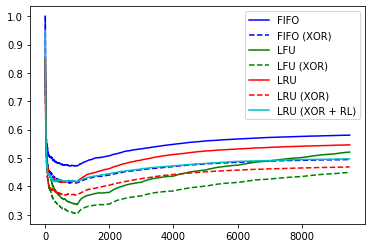

0.5806684210526316
0.49467894736842105
0.5209368421052631
0.44944736842105265
0.5464052631578947
0.4684
0.49719473684210524


In [6]:
M = 3
N = 9500
test_N = 500
num_of_video = 100
num_of_client = 20
cache_size = 20
zipf_param = 1
ch_interval = 1000
rho = 0.5

RL_connection, RL_test = RL_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)

t = [n for n in range(N)]

plt.plot(t,FIFO_connection,'b')
plt.plot(t,FIFO_Xconnection,'b--')
plt.plot(t,LFU_connection,'g')
plt.plot(t,LFU_Xconnection,'g--')
plt.plot(t,LRU_connection,'r')
plt.plot(t,LRU_Xconnection,'r--')
plt.plot(t,RL_connection,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

print(FIFO_connection[N-1])
print(FIFO_Xconnection[N-1])
print(LFU_connection[N-1])
print(LFU_Xconnection[N-1])
print(LRU_connection[N-1])
print(LRU_Xconnection[N-1])
print(RL_connection[N-1])

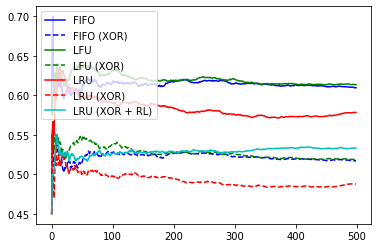

0.6095
0.517
0.6136
0.5191
0.5783
0.4878
0.5331


In [7]:
t = [n for n in range(test_N)]

plt.plot(t,FIFO_test,'b')
plt.plot(t,FIFO_Xtest,'b--')
plt.plot(t,LFU_test,'g')
plt.plot(t,LFU_Xtest,'g--')
plt.plot(t,LRU_test,'r')
plt.plot(t,LRU_Xtest,'r--')
plt.plot(t,RL_test,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

print(FIFO_test[test_N-1])
print(FIFO_Xtest[test_N-1])
print(LFU_test[test_N-1])
print(LFU_Xtest[test_N-1])
print(LRU_test[test_N-1])
print(LRU_Xtest[test_N-1])
print(RL_test[test_N-1])

# by rho

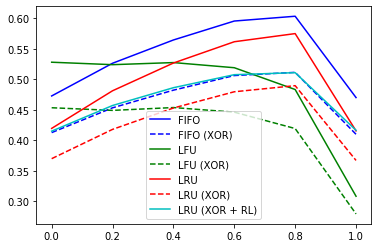

In [8]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

rho_list = [i*0.2 for i in range(6)]

for rho in rho_list:
    RL_connection, RL_test = RL_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
    FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
    LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
    LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num_of_video, num_of_client, cache_size, zipf_param)
    
    FIFO_connection_list.append(FIFO_connection[N-1])
    FIFO_Xconnection_list.append(FIFO_Xconnection[N-1])
    LFU_connection_list.append(LFU_connection[N-1])
    LFU_Xconnection_list.append(LFU_Xconnection[N-1])
    LRU_connection_list.append(LRU_connection[N-1])
    LRU_Xconnection_list.append(LRU_Xconnection[N-1])
    RL_connection_list.append(RL_connection[N-1])
    
    FIFO_test_list.append(FIFO_test[test_N-1])
    FIFO_Xtest_list.append(FIFO_Xtest[test_N-1])
    LFU_test_list.append(LFU_test[test_N-1])
    LFU_Xtest_list.append(LFU_Xtest[test_N-1])
    LRU_test_list.append(LRU_test[test_N-1])
    LRU_Xtest_list.append(LRU_Xtest[test_N-1])
    RL_test_list.append(RL_test[test_N-1])

plt.plot(rho_list,FIFO_connection_list,'b')
plt.plot(rho_list,FIFO_Xconnection_list,'b--')
plt.plot(rho_list,LFU_connection_list,'g')
plt.plot(rho_list,LFU_Xconnection_list,'g--')
plt.plot(rho_list,LRU_connection_list,'r')
plt.plot(rho_list,LRU_Xconnection_list,'r--')
plt.plot(rho_list,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

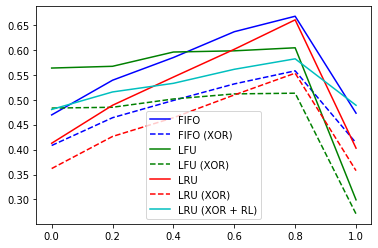

In [9]:
plt.plot(rho_list,FIFO_test_list,'b')
plt.plot(rho_list,FIFO_Xtest_list,'b--')
plt.plot(rho_list,LFU_test_list,'g')
plt.plot(rho_list,LFU_Xtest_list,'g--')
plt.plot(rho_list,LRU_test_list,'r')
plt.plot(rho_list,LRU_Xtest_list,'r--')
plt.plot(rho_list,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

# by Cache Size

In [10]:
rho = 0.5

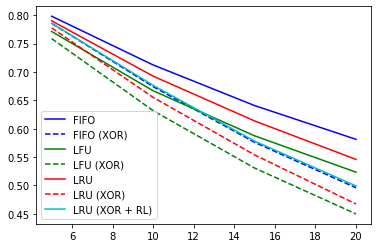

In [11]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

cache_sizes = [i*5 for i in range(1,5)]

for size in cache_sizes:
    RL_connection, RL_test = RL_Caching(M, N, num_of_video, num_of_client, size, zipf_param)
    FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num_of_video, num_of_client, size, zipf_param)
    LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num_of_video, num_of_client, size, zipf_param)
    LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num_of_video, num_of_client, size, zipf_param)
    
    FIFO_connection_list.append(FIFO_connection[N-1])
    FIFO_Xconnection_list.append(FIFO_Xconnection[N-1])
    LFU_connection_list.append(LFU_connection[N-1])
    LFU_Xconnection_list.append(LFU_Xconnection[N-1])
    LRU_connection_list.append(LRU_connection[N-1])
    LRU_Xconnection_list.append(LRU_Xconnection[N-1])
    RL_connection_list.append(RL_connection[N-1])
    
    FIFO_test_list.append(FIFO_test[test_N-1])
    FIFO_Xtest_list.append(FIFO_Xtest[test_N-1])
    LFU_test_list.append(LFU_test[test_N-1])
    LFU_Xtest_list.append(LFU_Xtest[test_N-1])
    LRU_test_list.append(LRU_test[test_N-1])
    LRU_Xtest_list.append(LRU_Xtest[test_N-1])
    RL_test_list.append(RL_test[test_N-1])

plt.plot(cache_sizes,FIFO_connection_list,'b')
plt.plot(cache_sizes,FIFO_Xconnection_list,'b--')
plt.plot(cache_sizes,LFU_connection_list,'g')
plt.plot(cache_sizes,LFU_Xconnection_list,'g--')
plt.plot(cache_sizes,LRU_connection_list,'r')
plt.plot(cache_sizes,LRU_Xconnection_list,'r--')
plt.plot(cache_sizes,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

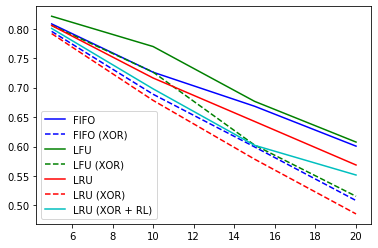

In [12]:
plt.plot(cache_sizes,FIFO_test_list,'b')
plt.plot(cache_sizes,FIFO_Xtest_list,'b--')
plt.plot(cache_sizes,LFU_test_list,'g')
plt.plot(cache_sizes,LFU_Xtest_list,'g--')
plt.plot(cache_sizes,LRU_test_list,'r')
plt.plot(cache_sizes,LRU_Xtest_list,'r--')
plt.plot(cache_sizes,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

# by Number of Clients

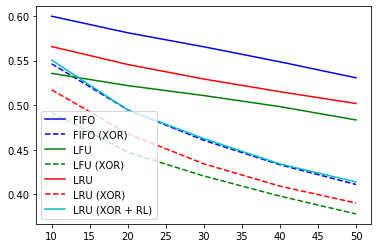

In [13]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

number_of_clients = [i*10 for i in range(1,6)]

for num in number_of_clients:
    RL_connection, RL_test = RL_Caching(M, N, num_of_video, num, size, zipf_param)
    FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num_of_video, num, size, zipf_param)
    LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num_of_video, num, size, zipf_param)
    LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num_of_video, num, size, zipf_param)
    
    FIFO_connection_list.append(FIFO_connection[N-1])
    FIFO_Xconnection_list.append(FIFO_Xconnection[N-1])
    LFU_connection_list.append(LFU_connection[N-1])
    LFU_Xconnection_list.append(LFU_Xconnection[N-1])
    LRU_connection_list.append(LRU_connection[N-1])
    LRU_Xconnection_list.append(LRU_Xconnection[N-1])
    RL_connection_list.append(RL_connection[N-1])
    
    FIFO_test_list.append(FIFO_test[test_N-1])
    FIFO_Xtest_list.append(FIFO_Xtest[test_N-1])
    LFU_test_list.append(LFU_test[test_N-1])
    LFU_Xtest_list.append(LFU_Xtest[test_N-1])
    LRU_test_list.append(LRU_test[test_N-1])
    LRU_Xtest_list.append(LRU_Xtest[test_N-1])
    RL_test_list.append(RL_test[test_N-1])

plt.plot(number_of_clients,FIFO_connection_list,'b')
plt.plot(number_of_clients,FIFO_Xconnection_list,'b--')
plt.plot(number_of_clients,LFU_connection_list,'g')
plt.plot(number_of_clients,LFU_Xconnection_list,'g--')
plt.plot(number_of_clients,LRU_connection_list,'r')
plt.plot(number_of_clients,LRU_Xconnection_list,'r--')
plt.plot(number_of_clients,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

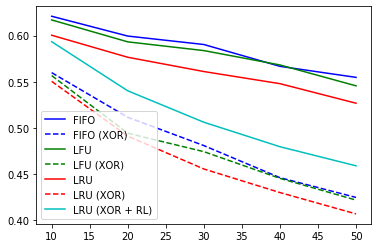

In [14]:
plt.plot(number_of_clients,FIFO_test_list,'b')
plt.plot(number_of_clients,FIFO_Xtest_list,'b--')
plt.plot(number_of_clients,LFU_test_list,'g')
plt.plot(number_of_clients,LFU_Xtest_list,'g--')
plt.plot(number_of_clients,LRU_test_list,'r')
plt.plot(number_of_clients,LRU_Xtest_list,'r--')
plt.plot(number_of_clients,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

# by Number of Videos

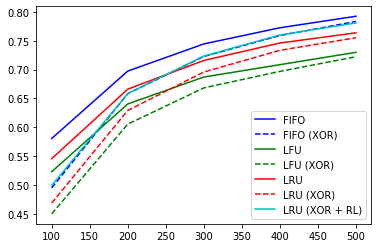

In [15]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

number_of_videos = [i*100 for i in range(1,6)]

for num in number_of_videos:
    RL_connection, RL_test = RL_Caching(M, N, num, num_of_client, size, zipf_param)
    FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num, num_of_client, size, zipf_param)
    LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num, num_of_client, size, zipf_param)
    LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num, num_of_client, size, zipf_param)
    
    FIFO_connection_list.append(FIFO_connection[N-1])
    FIFO_Xconnection_list.append(FIFO_Xconnection[N-1])
    LFU_connection_list.append(LFU_connection[N-1])
    LFU_Xconnection_list.append(LFU_Xconnection[N-1])
    LRU_connection_list.append(LRU_connection[N-1])
    LRU_Xconnection_list.append(LRU_Xconnection[N-1])
    RL_connection_list.append(RL_connection[N-1])
    
    FIFO_test_list.append(FIFO_test[test_N-1])
    FIFO_Xtest_list.append(FIFO_Xtest[test_N-1])
    LFU_test_list.append(LFU_test[test_N-1])
    LFU_Xtest_list.append(LFU_Xtest[test_N-1])
    LRU_test_list.append(LRU_test[test_N-1])
    LRU_Xtest_list.append(LRU_Xtest[test_N-1])
    RL_test_list.append(RL_test[test_N-1])

plt.plot(number_of_videos,FIFO_connection_list,'b')
plt.plot(number_of_videos,FIFO_Xconnection_list,'b--')
plt.plot(number_of_videos,LFU_connection_list,'g')
plt.plot(number_of_videos,LFU_Xconnection_list,'g--')
plt.plot(number_of_videos,LRU_connection_list,'r')
plt.plot(number_of_videos,LRU_Xconnection_list,'r--')
plt.plot(number_of_videos,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

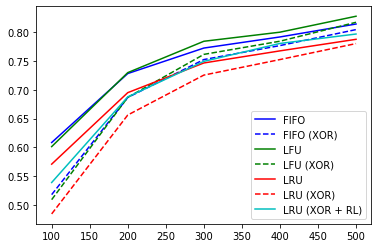

In [16]:
plt.plot(number_of_videos,FIFO_test_list,'b')
plt.plot(number_of_videos,FIFO_Xtest_list,'b--')
plt.plot(number_of_videos,LFU_test_list,'g')
plt.plot(number_of_videos,LFU_Xtest_list,'g--')
plt.plot(number_of_videos,LRU_test_list,'r')
plt.plot(number_of_videos,LRU_Xtest_list,'r--')
plt.plot(number_of_videos,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

# by zipf parameter

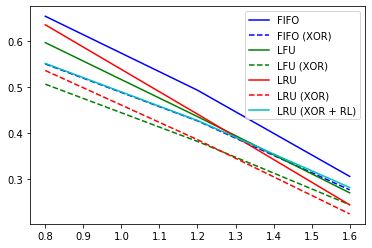

In [17]:
FIFO_connection_list, FIFO_test_list = [], []
FIFO_Xconnection_list, FIFO_Xtest_list = [], []
LFU_connection_list, LFU_test_list = [], []
LFU_Xconnection_list, LFU_Xtest_list = [], []
LRU_connection_list, LRU_test_list = [], []
LRU_Xconnection_list, LRU_Xtest_list = [], []
RL_connection_list, RL_test_list = [], []

zipf_parameters = [i*0.4 for i in range(2, 5)]

for zipf in zipf_parameters:
    RL_connection, RL_test = RL_Caching(M, N, num_of_video, num_of_client, size, zipf)
    FIFO_connection, FIFO_Xconnection, FIFO_test, FIFO_Xtest = FIFO_Caching(M, N, num_of_video, num_of_client, size, zipf)
    LFU_connection, LFU_Xconnection, LFU_test, LFU_Xtest = LFU_Caching(M, N, num_of_video, num_of_client, size, zipf)
    LRU_connection, LRU_Xconnection, LRU_test, LRU_Xtest = LRU_Caching(M, N, num_of_video, num_of_client, size, zipf)
    
    FIFO_connection_list.append(FIFO_connection[N-1])
    FIFO_Xconnection_list.append(FIFO_Xconnection[N-1])
    LFU_connection_list.append(LFU_connection[N-1])
    LFU_Xconnection_list.append(LFU_Xconnection[N-1])
    LRU_connection_list.append(LRU_connection[N-1])
    LRU_Xconnection_list.append(LRU_Xconnection[N-1])
    RL_connection_list.append(RL_connection[N-1])
    
    FIFO_test_list.append(FIFO_test[test_N-1])
    FIFO_Xtest_list.append(FIFO_Xtest[test_N-1])
    LFU_test_list.append(LFU_test[test_N-1])
    LFU_Xtest_list.append(LFU_Xtest[test_N-1])
    LRU_test_list.append(LRU_test[test_N-1])
    LRU_Xtest_list.append(LRU_Xtest[test_N-1])
    RL_test_list.append(RL_test[test_N-1])

plt.plot(zipf_parameters,FIFO_connection_list,'b')
plt.plot(zipf_parameters,FIFO_Xconnection_list,'b--')
plt.plot(zipf_parameters,LFU_connection_list,'g')
plt.plot(zipf_parameters,LFU_Xconnection_list,'g--')
plt.plot(zipf_parameters,LRU_connection_list,'r')
plt.plot(zipf_parameters,LRU_Xconnection_list,'r--')
plt.plot(zipf_parameters,RL_connection_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()

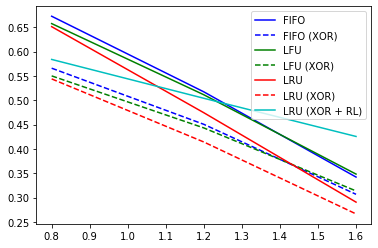

In [18]:
plt.plot(zipf_parameters,FIFO_test_list,'b')
plt.plot(zipf_parameters,FIFO_Xtest_list,'b--')
plt.plot(zipf_parameters,LFU_test_list,'g')
plt.plot(zipf_parameters,LFU_Xtest_list,'g--')
plt.plot(zipf_parameters,LRU_test_list,'r')
plt.plot(zipf_parameters,LRU_Xtest_list,'r--')
plt.plot(zipf_parameters,RL_test_list,'c')
plt.legend(['FIFO', 'FIFO (XOR)', 'LFU', 'LFU (XOR)', 'LRU', 'LRU (XOR)', 'LRU (XOR + RL)'])
plt.show()